# Running a Random Forest

Before we start with the computations, we need to do a few things; we'll do the following :
1. Import the relevant libraries that we will use;
2. Do a little bit of data management and small manipulations in the data set.

In [3]:
# Let's start by importing the libraries we will need :
import pandas as pd
import numpy as np
import seaborn as sns  # for plots
import matplotlib.pyplot as plt  # as plt is sort of a nickname for the library because it is too long.
import statsmodels.formula.api as smf  # statsmodels
import statsmodels.stats.multicomp as multi  # statsmodels and posthoc test
import statsmodels.api as sm  # Statsmodel for the qqplots
import scipy.stats  # For the Chi-Square test of independance

# to prevent the depreciation warning of the datetools of pandas
from pandas.core import datetools
# 
import os 

# Machine learning
# Libraries for decision trees, and random forest

from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics

import graphviz

# Feature Importance - for the random trees
from sklearn import datasets
from sklearn.ensemble import ExtraTreesClassifier

In [4]:
# IMPORTANT BUG FIXS !!!

# Because, by default, the Pandas library often displays an abbreviated list of rows and columns
# from our data frame. We are going to add additional set option statements following the library import syntax 
# that requests a display of the maximum number of rows and columns. 

# The default in Python, limits this display to a subset of the data frame, 
# and so including display, max, columns, or rows, none, removes that limit 
# and allows all rows and columns to be displayed.

# Set PANDAS to show all columns in DataFrame
pd.set_option('display.max_columns', None)
# Set PANDAS to show all rows in DataFrame
pd.set_option('display.max_rows', None)

# bug fix for display formats to avoid run time errors
pd.set_option('display.float_format', lambda x:'%f'%x)

In [5]:
# Importing the data set
df = pd.read_csv("ool_pds.csv", low_memory = False)

### Data management

In [6]:
# Let's do a bit of data management on the variables that we will be working with
df["W1_P20"] = df["W1_P20"].replace(-1, np.nan)
df["W1_G2"] = df["W1_G2"].replace(-1, np.nan)
df["W1_F1"] = df["W1_F1"].replace(-1, np.nan)
df["W1_D1"] = df["W1_D1"].replace(-1, np.nan)
df["W1_D1"] = df["W1_D1"].replace(998, np.nan)
df["W1_A12"] = df["W1_A12"].replace(-1, np.nan)
df["W1_C1"] = df["W1_C1"].replace(-1, np.nan)
df["W1_A1"] = df["W1_A1"].replace(-1, np.nan)
df["W1_M1"] = df["W1_M1"].replace(-1, np.nan)
df["W1_P11"] = df["W1_P11"].replace(-1, np.nan)

In [7]:
def economy_situation(row):
    if row["W1_G2"] == 1:
        return 1
    if row["W1_G2"] == 2:
        return 0
    if row["W1_G2"] == 3:
        return 0
# This variable is then added to the dataframe
df["economy_situation"] = df.apply(lambda row: economy_situation(row), axis=1)
#%%
df["economy_situation"] = df["economy_situation"].astype("category")

In [10]:
# Because random forest analyses cannot handle any NA's in our data set,
# the next step is to create a clean data frame that drops all NA's.
df_clean = df.dropna()

Setting the new data frame called df_clean, I can now take a look at various characteristics of the data by using the "dtypes" and "describe" functions to examine data types and summary statistics.

In [11]:
df_clean.describe()

,CASEID,W1_CASEID,W1_WEIGHT1,W1_WEIGHT2,W1_WEIGHT3,W1_A1,W1_A2,W1_A4,W1_A10,W1_A11,W1_A12,W1_B1,W1_B2,W1_B3,W1_B4,W1_C1,W1_C2,W1_D1,W1_D2,W1_D3,W1_D4,W1_D5,W1_D6,W1_D7,W1_D8,W1_D9,W1_D10,W1_D11,W1_D12,W1_D13,W1_D14,W1_D15,W1_D16,W1_D17,W1_D18,W1_D19,W1_D20,W1_E1,W1_E3,W1_E61_A,W1_E61_B,W1_E61_C,W1_E61_D,W1_E62_A,W1_E62_B,W1_E62_C,W1_E62_D,W1_E63_A,W1_E63_B,W1_E63_C,W1_E63_D,W1_E64_A,W1_E64_B,W1_E64_C,W1_E64_D,W1_E7,W1_E9_A,W1_E9_B,W1_E9_C,W1_E9_D,W1_E9_REFUSED,W1_F1,W1_F2,W1_F3,W1_F4_A,W1_F4_B,W1_F4_C,W1_F4_D,W1_F4_E,W1_F5_A,W1_F5_B,W1_F5_C,W1_F5_D,W1_F5_E,W1_F6,W1_G2,W1_G3A,W1_H1,W1_H2,W1_H3,W1_H4,W1_H5,W1_H6,W1_H7,W1_H8,W1_I1,W1_I2,W1_J1_A,W1_J1_B,W1_J1_C,W1_J1_D,W1_J1_E,W1_J1_F,W1_J1_G,W1_J2,W1_J3A_A,W1_J3A_B,W1_J3A_C,W1_K1_A,W1_K1_B,W1_K1_C,W1_K1_D,W1_K4,W1_K5,W1_L1_A,W1_L1_B,W1_L1_C,W1_L2_1,W1_L2_2,W1_L2_3,W1_L2_4,W1_L2_5,W1_L2_REFUSED,W1_L3,W1_L4_A,W1_L4_B,W1_L4_C,W1_L4_D,W1_L5_A,W1_L5_B,W1_L5_C,W1_L5_D,W1_L5_E,W1_L5_F,W1_M1,W1_M1A,W1_M5,W1_M3,W1_M4,W1_N1A,W1_N1B,W1_N1C,W1_N1D,W1_N1E,W1_N1F,W1_N1G,W1_N1H,W1_N1I,W1_N1J,W1_N1K,W1_N1L,W1_N1M,W1_N1N,W1_O1,W1_O3,W1_O4,W1_O5,W1_P2,W1_P3,W1_P4,W1_P5,W1_P5A,W1_P6,W1_P8,W1_P9,W1_P10,W1_P11,W1_P13,W1_P14,W1_P15,W1_P16A,W1_P16B,W1_P16C,W1_P16D,W1_P16E,W1_P16F,W1_P16G,W1_P16H,W1_P16I,W1_P16J,W1_P16K,W1_P16L,W1_P16M,W1_P16_REFUSED,W1_P17,W1_P20,W1_P21,W1_ORDER_Q1,W1_Q1_A,W1_Q1_B,W1_ORDER_M13,W1_ORDER_A1,W1_ORDER_A2,W1_ORDER_A12,W1_ORDER_B1,W1_ORDER_B2,W1_ORDER_B3,W1_ORDER_B4,W1_ORDER_C2,W1_ORDER_E2,W1_ORDER_E2A,W1_ORDER_F1,W1_ORDER_F1A,W1_ORDER_F2,W1_ORDER_F2A,W1_ORDER_F3,W1_ORDER_F4,W1_ORDER_F5,W1_ORDER_G2,W1_ORDER_G3A,W1_ORDER_H1,W1_ORDER_I1,W1_ORDER_J1,W1_ORDER_J3A,W1_ORDER_K1,W1_ORDER_L4_A,W1_ORDER_L4_B,W1_ORDER_L4_C,W1_ORDER_L4_D,W1_ORDER_L5_A,W1_ORDER_L5_B,W1_ORDER_L5_C,W1_ORDER_L5_D,W1_ORDER_L5_E,W1_ORDER_L5_F,W1_ORDER_M3,W1_ORDER_O1,PPAGE,PPAGECAT,PPAGECT4,PPEDUC,PPEDUCAT,PPETHM,PPGENDER,PPHHHEAD,PPHHSIZE,PPHOUSE,PPINCIMP,PPMARIT,PPMSACAT,PPREG4,PPREG9,PPRENT,PPSTATEN,PPT01,PPT1317,PPT18OV,PPT25,PPT612,PPWORK,PPNET
count,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1935.000000,1

# Running a Random Forest

# The research question is :
 **To what extent is the perception of the US situation associated with the level of income ?**

# The variables of interest in our research question
"W1_P20 is the Personnal Annual income")
"W1_G2 is the US economy's situation")
"W1_F1 is the Percentage of how the respondants think about the future")
Explanatory variables :

**Target is the US economy's situation**, this variable has been managed previously. The _W1_G2_ variable has been transformed into a two level categorical variable, called **economy_situation**.

** The variables used in the analysis are the following :**
Predictors (Xi) that we have tested:
- W1_A1 How interested are you in what’s going on in government and politics?
- W1_C1: Generally speaking, do you usually think of yourself as a Democrat, a Republican, an Independent, or something else?
- W1_P20 Which of the following income groups includes YOUR personal annual income (Do not include the income of other members of your household)?
- PPAGE: Age
- PPINCIMP: Household Income
- W1_P11: Is anyone in your household currently unemployed?
- PPETHM: Race / Ethnicity

In [12]:
predictors = df_clean[["W1_A1" ,"W1_C1", "W1_P20", "PPAGE", "PPINCIMP", "W1_P11", "PPETHM"]]
targets = df_clean.economy_situation

In [13]:
"""
Next I set my explanatory and response, or target variables, and
then include the train test split function for predictors and target.
And set the size ratio to 60% for the training sample, and 40% for
the test sample.

"""

pred_train, pred_test, tar_train, tar_test  =   train_test_split(predictors, targets, test_size= 0.4)
# 3) Here I request the shape of these predictor and target training and
# test samples.

# This is the training sample : observations (% of the ratio of our original sample, and nb of explanatory variables")
print("Training sample : observations and explanatory variables")
print(pred_train.shape)

print("The test sample : observations and explanatory variables")
print(pred_test.shape)

Training sample : observations and explanatory variables
(1161, 7)
The test sample : observations and explanatory variables
(774, 7)


In [14]:
# From the sklearn library, we'll import the RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier

In [15]:
"""
Now that training and test data sets have already been created, we'll initialize the random forest classifier from SK Learn and indicate n_estimators= nb of variables.
n_estimators are the number of trees you would build with the random forest algorithm.
 """
classifier = RandomForestClassifier(n_estimators = 7)
classifier = classifier.fit(pred_train, tar_train)

# Then we do the prediction on the test data set
predictions = classifier.predict(pred_test)

In [16]:
print("This is the confusion matrix :")
sklearn.metrics.confusion_matrix(tar_test, predictions)

This is the confusion matrix :


array([[502,  78],
       [160,  34]])

In [17]:
print("This is the accuracy score :")
sklearn.metrics.accuracy_score(tar_test, predictions)

This is the accuracy score :


0.69250645994832039

69,25 % of the individuals where classified correctly. Sence, we don't interpret individual trees in a random forest, the most helpful information to be gotten from a forest is the measured importance for each explanatory variable (or the features).

In [18]:
model = ExtraTreesClassifier()
model.fit(pred_train, tar_train)
print(model.feature_importances_)

[ 0.11760887  0.08807666  0.19737701  0.29366957  0.20428945  0.03364923
  0.0653292 ]


Bases on the results the most important explanatory variable is the **Age**, followed by the **Household Income**, the **income group**, in determining the perception of the US economy's situation.

In [20]:
"""
So were "n" number of trees actually needed to get this correct rate of classification?
To determine what growing larger number of trees has brought us in terms of correct
classification.
We're going to use code that builds for us different numbers of trees,
from one to "n", and provides the correct classification rate for each.
This code will build for us random forest classifier from one to "n",
and then finding the accuracy score for each of those trees from one to "n",
and storing it in an array.

Running a different number of trees and see the effect of that on the accuracy of the prediction
"""

trees=range(4)
accuracy=np.zeros(4)

for idx in range(len(trees)):
   classifier=RandomForestClassifier(n_estimators=idx + 1)
   classifier=classifier.fit(pred_train,tar_train)
   predictions=classifier.predict(pred_test)
   accuracy[idx]=sklearn.metrics.accuracy_score(tar_test, predictions)

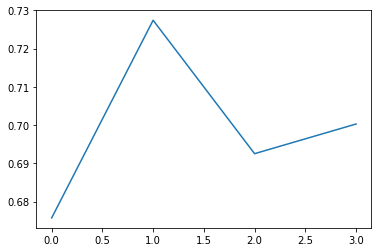

In [24]:
%matplotlib inline
plt.cla()
plt.plot(trees, accuracy)

From the plot of the accuracy score when we add new trees in the forest
We don't need all these variables to predict the perception of the US economy's
situation.

## Summary

Random forest analysis was performed to evaluate the importance of a series of explanatory variables (interested in government and politics, political affiliation, personal income level, age, household income, unemployment, and race/ethnicity), in predicting a binary categorical response variable (the US economy's situation). The explanatory variables were included as possible contributors to a random forest evaluating the US economy's situation.

The explanatory variables with the highest relative importance scores were the **Age**, followed by the **Household Income**, and the **personal income**, in determining the perception of the US economy's situation.

The accuracy of the random forest was 69,25 %, with the following growing of multiple trees rather than a single tree, adding little to the overall accuracy of the model, and suggesting that interpretation of a single decision tree may be suitable.

